# Read data and perform fit to find PE/MeV

#### Created by Jorge Torres, 4/20/2022
#### Updated by Andrew Zheng, 4/30/2022
This notebook reads the data produced by the CAEN 5202 module when taking background runs for the prototype panels. It then fits the PE peaks to find the PE/MeV. All important files and figures are saved in a directory labelled /figures-YYYYMMDDHHMMSS, where the datetime associated with the folder is when the script was run.

### Import needed libraries

In [68]:
import ROOT

import sys
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle, TCanvas
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

In [69]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

### Import parser that Tom wrote. This is containted in the file named $\texttt{dt5202.py}$ in this folder

In [111]:
from dt5202 import dt5202_crunch
#from dt5202oldDAQ import dt5202_crunch as dt5202_crunchOld
ped = 50 #pedestal correction

In [112]:
#Import data files
sourceFolder = "/home/dt592/data/BkgSwirlyDin1_10min_20230711/"
# sourceFolder = "/home/dt592/data/aaronthick20230517/"
#folder_name = os.getcwd() # could use this if analysis code is in the same directory as data
#loading all files in this directory
onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]
print(onlyfiles)
data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=10000000, num_ch=1))

data = data_list[0]

for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

#f = sourceFolder+'Run0_list.dat'
#data = dt5202_crunch(f, num_ev=10000000, num_ch=2)

['Run0_list.dat']
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1689087020711)]
((33, 0, 1.68908702e+09, 0, 256), (8, 3, 3394, 8083))


In [113]:
data.shape

(135025,)

In [114]:
# Create folder based on datetime and path for where we will save the images.
# Get current date and time
# This way, if this code block needs to be run again with updated data, we will save files into a new folder
now = datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")
directory_name = '/figures-' + dt_string
# directory_name = '/figures_gainPed50_HG87-5_LG87-5_HD200'
figure_folder = os.getcwd() + directory_name
print(figure_folder)

os.mkdir(figure_folder)                                
print("Figures Directory created at path '% s'" % figure_folder)

/vast/palmer/home.grace/dt592/Geant4Work/gamma_sim/gamma_sim-build/figures-20230711140154
Figures Directory created at path '/vast/palmer/home.grace/dt592/Geant4Work/gamma_sim/gamma_sim-build/figures-20230711140154'


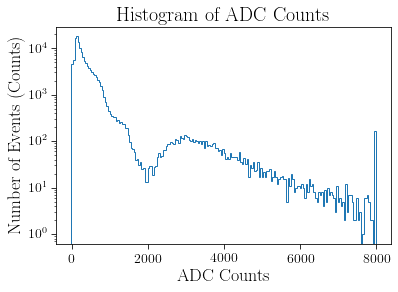

In [115]:
#plotting High Gain Data to View SPE peaks
#plt.hist(data['data']['high_gain'][:,0]-ped, bins=300, range=(500,2000),
 #        histtype='step');
plt.hist(data['data']['low_gain']-ped, bins=200,
         histtype='step');
# plt.xlim(0,4000)
# plt.ylim(0,1000)
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts')
plt.yscale('log')
# Can work on naming scheme
# plt.savefig(figure_folder + '/' + 'ADCHist.png')

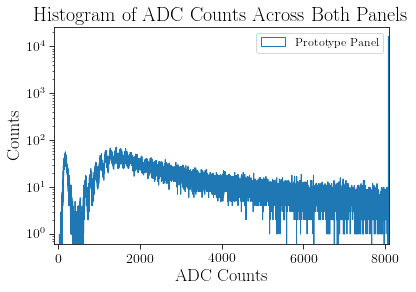

In [116]:
plt.hist(data['data']['high_gain'], bins=8100, range=(0,8100),
         histtype='step', label=["Prototype Panel", "Mini Panel"]);
# plt.xlim(4040,4055)
plt.xlabel('ADC Counts')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
plt.xlim(-100,8100)
plt.title('Histogram of ADC Counts Across Both Panels')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'ADCHist_HighGainBoth.png')

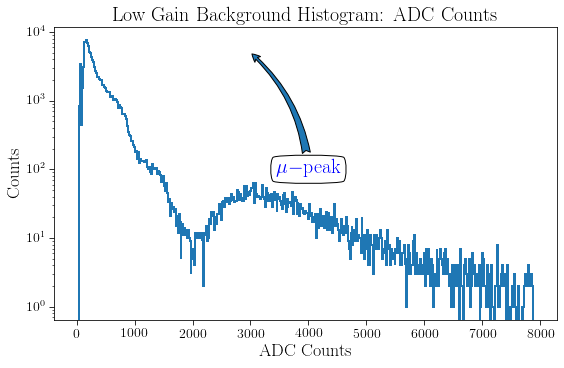

In [117]:
plt.figure(figsize=(8,5))

#plt.hist(data['data']['low_gain'][:,0],
#         histtype='step', lw = 2., range = (10,7900), bins = 500);
plt.hist(data['data']['low_gain'],
         histtype='step', lw = 2., range = (10,7900), bins = 500);
# plt.xlim(0,8000)
plt.xlabel('ADC Counts')
plt.ylabel('Counts')
plt.yscale('log')
plt.annotate("$\gamma-$background", color = "blue",
            xy=(300, 1E6), xycoords='data',
            xytext=(3.3E3, 1E6), textcoords='data',
            size=20, va="center", ha="center",bbox=dict(boxstyle="round4", fc="w"),
            arrowprops=dict(arrowstyle="fancy",
                            connectionstyle="arc3,rad=0.2"),
            )

plt.annotate("$\mu-$peak", color = "blue",
            xy=(3000, 5E3), xycoords='data',
            xytext=(4E3, 1E2), textcoords='data',
            size=20, va="center", ha="center",bbox=dict(boxstyle="round4", fc="w"),
            arrowprops=dict(arrowstyle="fancy",
                            connectionstyle="arc3,rad=0.2"),
            )
# plt.xlim(-100,2100)
# plt.title('Histogram of ADC Counts: Low Gain')
# Can work on naming scheme
plt.tight_layout()
plt.title("Low Gain Background Histogram: ADC Counts")
plt.savefig(figure_folder + '/' + 'lowgainbackground.png')

## Fit multi-gaussian to peaks

Guess the fitting values. I'd suggest leave as it is, since it took me a long time to fine tune and it seems to be very finicky.
<br>This calculates the spe peaks which can be used to convert ADC to PE. (spe in Tom's code).

In [118]:
def make_model(num):
    pref = "f{0}_".format(num)
    model = GaussianModel(prefix = pref)
    model.set_param_hint(pref+'amplitude', value=amplitude[num], min=1, max=200*amplitude[num])
    model.set_param_hint(pref+'center', value=center[num], min=center[num]-10, max=center[num]+10)
    model.set_param_hint(pref+'sigma', value=width[num], min=1, max=50)
    return model

Text(0.5, 0, 'Integrated ADC')

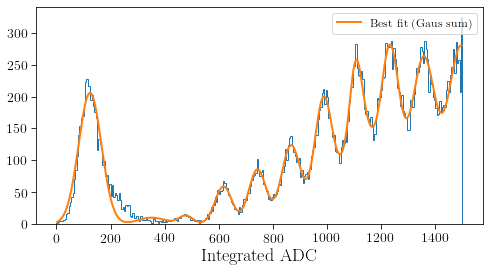

In [119]:
plt.figure(figsize=(8,4))

#bin_heights, bin_borders, _ = plt.hist(np.array(data['data']['high_gain'][:,0]-ped), bins='auto',range=(550,2000), density=False, histtype='step');
#bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

bin_heights, bin_borders, _ = plt.hist(np.array(data['data']['high_gain']-ped), bins=300,range=(0,1500), density=False, histtype='step');
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

peaks_in_interval = scipy.signal.find_peaks_cwt(bin_heights, widths=2)
number_of_peaks = len(peaks_in_interval)
amplitude = bin_heights[peaks_in_interval]
width = np.zeros(number_of_peaks) + 10
center = bin_centers[peaks_in_interval]

mod = None
for i in range(len(peaks_in_interval)):
    this_mod = make_model(i)
    if mod is None:
        mod = this_mod
    else:
        mod = mod + this_mod

offset = ConstantModel()
offset.set_param_hint('c', value=np.average(bin_heights))
mod = mod #+ offset

out=mod.fit(bin_heights, x=bin_centers)

plt.plot(bin_centers, out.best_fit, label='Best fit (Gaus sum)', lw = 2)
# plt.plot(bin_centers, out.init_fit, 'r--', label='fit with initial values')
plt.legend()
plt.xlabel("Integrated ADC")

# sigmas = np.array(sigmas)
# sigm_avg.append(sigmas.mean())
# sigm_std.append(sigmas.std()/np.sqrt(len(sigmas)))
# redchi.append(out.redchi)
# plt.yscale('log')
# plt.ylim(1,1E5)

#### Print the fit parameters

In [120]:
out.params.pretty_print(columns=['value', 'min', 'max', 'stderr'])

Name              Value      Min      Max   Stderr
f0_amplitude   2.173e+04        1 4.32e+04     None
f0_center           124    107.5    127.5     None
f0_fwhm           99.19     -inf      inf     None
f0_height         205.8     -inf      inf     None
f0_sigma          42.12        1       50     None
f10_amplitude      8733        1 5.18e+04     None
f10_center         1252     1242     1262     None
f10_fwhm          103.6     -inf      inf     None
f10_height        79.19     -inf      inf     None
f10_sigma         43.99        1       50     None
f11_amplitude  2.725e+04        1 5.48e+04     None
f11_center         1358     1358     1378     None
f11_fwhm          101.3     -inf      inf     None
f11_height        252.7     -inf      inf     None
f11_sigma         43.03        1       50     None
f12_amplitude  3.496e+04        1 4.14e+04     None
f12_center         1496     1482     1502     None
f12_fwhm          117.7     -inf      inf     None
f12_height          279     

#### Calculate the peak center differences from the fit parameters and average them out

In [121]:
peak_fitCenter = []
for i in range(len(peaks_in_interval)):
    try:
        print(out.values["f%i_center"%(i+1)]-out.values["f%i_center"%i])
        peak_fitCenter.append(out.values["f%i_center"%(i+1)]-out.values["f%i_center"%i])
    except:
        break
peak_fitCenter = np.array(peak_fitCenter)

228.50036765627542
125.47359372711492
139.28596748486973
125.44155918966567
124.62681778126523
119.76986432895421
118.73262009539633
11.784910221259224
113.22662049471228
21.64814545914055
105.00990121762175
138.95397922521897


In [122]:
ADC_to_PE = peak_fitCenter.mean().round() #the mean, rounded since ADC counts are integers
spe = ADC_to_PE
#This number corresponds to the ADC/P.E.
print(ADC_to_PE)

114.0


In [123]:
plt.hist((data['data']['high_gain'][:,0]-ped)/ADC_to_PE, bins=211, range=(0,15),
         histtype='step',color='C1');
plt.xlabel('~PE')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid()
plt.ylim(100,)
plt.title('PE Peaks')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEPeaks.png')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Fixed

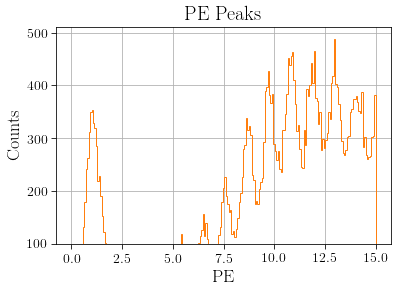

In [124]:
plt.hist((data['data']['high_gain']-ped)/ADC_to_PE, bins=211, range=(0,15),
         histtype='step',color='C1');
plt.xlabel('~PE')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid()
plt.ylim(100,)
plt.title('PE Peaks')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEPeaks.png')

In [84]:
d = (data['data']['high_gain'][:,0]-ped)/spe

n_ev = len(d)
n_steps = 100
n = n_ev // n_steps

for i in range(n_steps):
    plt.hist(d[i*n:(i+1)*n], bins=211, range=(0,15),
             histtype='step');
plt.xlabel('~PE')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid()
plt.ylim(1,)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

(1.0, 325.5)

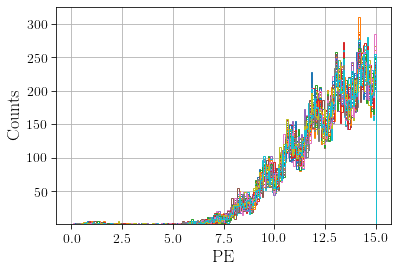

In [85]:
d = (data['data']['high_gain']-ped)/spe

n_ev = len(d)
n_steps = 100
n = n_ev // n_steps

for i in range(n_steps):
    plt.hist(d[i*n:(i+1)*n], bins=211, range=(0,15),
             histtype='step');
plt.xlabel('~PE')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid()
plt.ylim(1,)

## Calculate the ratio between high gain counts and low gain counts

This block uses Python's linear fit function to estimate the ratio of the counts between the high and low gain channels. Due to the count limit of the high gain channel, we will only use low gain data up to when the high gain threshhold is met.

In [86]:
# Find maximum of high gain counts, then see when the low gain counts reaches that threshhold.
max_high_gain = max(data['data']['high_gain']-ped) - ped

In [87]:
# Initialize the low gain limit we want to use in the linear fit to a very high value.
# The low gain limit will not exceed the max_high_gain value, so this initialization should be sufficient for minimization.
low_gain_limit = max_high_gain

In [88]:
# Find the minimum point in low gain counts that reaches the threshold.
for data_point_index in range(len(data['data']['low_gain'])):
    if max_high_gain == data['data']['high_gain'][data_point_index] - ped:
        if (data['data']['low_gain'][data_point_index] - ped) < low_gain_limit:
            low_gain_limit = (data['data']['low_gain'][data_point_index] - ped)

print(low_gain_limit)

707


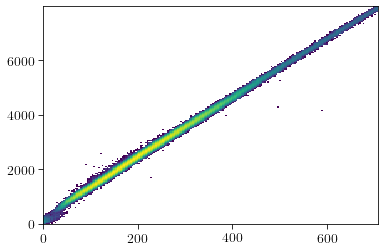

In [89]:
# Plot histogram within this range above, as we are only interested in coincident data
plt.hist2d(data['data']['low_gain']-ped, (data['data']['high_gain']-ped), bins=200, range=((0,low_gain_limit),(0,max_high_gain)), norm=LogNorm());
# print(max(data['data']['low_gain'][:,0])-ped)
# print(max(data['data']['high_gain'][:,0]-ped)/rat)
# plt.plot(np.linspace(start=0,stop=1000,num=1000)) 

In [90]:
# Initialize two new np arrays with high and low gain count data in the ranges defined above
low_gain = []
high_gain = []

In [91]:
# Low gain is always going to have data above the threshhold, so we will only add data from the dataset that has a low gain count under the limit set above.
# Create two new np arrays: low gain counts and high gain counts that only include data within the minimum of the maximums
for data_point_index in range(len(data['data']['low_gain'])):
    if data['data']['low_gain'][data_point_index] - ped <= low_gain_limit:
        low_gain.append(data['data']['low_gain'][data_point_index] - ped)
        high_gain.append((data['data']['high_gain'][data_point_index] - ped))

In [92]:
#Fit a line to the histogram
m, b = np.polyfit(low_gain, high_gain, 1)
print('Best Fit: y = ' + str(round(m, 2)) + 'x + ' + str(round(b,2)))
print('Ratio between high gain counts and low gain counts: ' + str(round(m, 2)))

Best Fit: y = 11.04x + 250.45
Ratio between high gain counts and low gain counts: 11.04


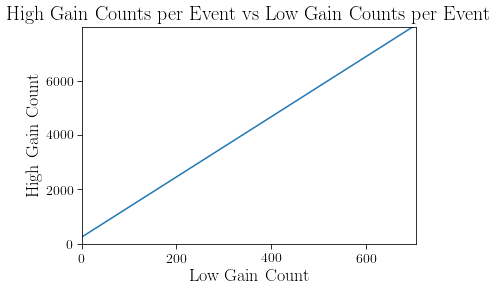

In [93]:
# Plot line of best fit
plt.plot([0, low_gain_limit], [m*0+b, m*low_gain_limit+b])
# plt.plot(data['data']['low_gain'][:,0]-ped, m*(data['data']['low_gain'][:,0]-ped)+b)

# Set Plot Descriptors and Ranges
plt.xlim(0,low_gain_limit)
plt.ylim(0,max_high_gain)
plt.title('High Gain Counts per Event vs Low Gain Counts per Event')
plt.xlabel('Low Gain Count')
plt.ylabel('High Gain Count')

rat = m

# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'Hist_HighLow.png')

In [95]:
print("Ratio between high and low gain counts: " + str(rat))
print("Conversion from ADC to PE: " + str(spe))

Ratio between high and low gain counts: 11.037464891979246
Conversion from ADC to PE: 101.0


## Some graphs, converting ADC to PE and normalizing high gain and low gain counts by estimated ratio

In [96]:
plt.hist(data['data']['low_gain'][:,0], bins='auto',
         histtype='step');
# plt.xlim(0,4000)
# plt.ylim(0,1000)
plt.title('Background Spectrum in ADC')
plt.xlabel('ADC Counts')
plt.ylabel('Counts')
plt.yscale('log')
plt.savefig(figure_folder + '/' + 'ADCBackgroundSpectrum.png')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [97]:
d = data['data']['low_gain'][:,0]-ped
plt.hist(d.astype('float64')*rat/spe, bins=200, range=(0,700),histtype='step');
d = data['data']['high_gain'][:,0]-ped
plt.hist(d.astype('float64')/spe, bins=200, range=(0,700),histtype='step');
plt.yscale('log')
plt.title('Background Spectrum in PE')
plt.xlabel("PE")
plt.ylabel("Counts")
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum.png')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [98]:
plt.figure(figsize=(8,8))
t_25 = data['data']['low_gain'][:,0]
t_6 = data['data']['low_gain'][:,1]
plt.hist2d(t_6.astype('float64'),t_25.astype('float64'),bins=100, range=((0,max(data['data']['low_gain'][:,0])/2),(0,max(data['data']['low_gain'][:,1]))), norm=LogNorm(vmax=1000))
# plt.xlim(0,2000)
plt.xlabel('6x6 tile LG')
plt.ylabel('25x25 tile LG')
plt.title('Low Gain Coincidence Histogram')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'CoincidenceHistogram.png')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 576x576 with 0 Axes>

In [99]:
filter = data['data']['low_gain'][:,1] > 250
d = (data['data']['low_gain'][:,0]-ped)*rat/spe
plt.hist(d, bins=200, range=(10,700), histtype='step', label='No-Coinc.');
plt.hist(d[filter], bins=200, range=(10,700), histtype='step', label='Coinc');
plt.ylim(0,max(d[filter])*3/2)
plt.xlabel('PE');
plt.legend();
plt.title('Low Gain Background Histogram of Coincident Events')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'LowGainPEBackgroundSpectrum_Coincidence.png')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [100]:
filter = data['data']['low_gain'][:,1] > 250
d = (data['data']['low_gain'][:,0]-ped)*rat/spe

h1,bins = np.histogram(d, bins=740, range=(10,750))
h2,bins = np.histogram(d[filter], bins=740, range=(10,750))

area_ratio = (6*6)/(25*25)
plt.stairs(h1*area_ratio, bins, label='No-Coinc., Area-Scaled')
plt.stairs(h2, bins, label='Coinc')
plt.ylim(0,500)
plt.legend()
plt.xlabel('PE')
plt.ylabel('Counts')
plt.vlines(x=265, ymin=0,ymax=5000, linestyles='--', color='k', alpha=0.5)
plt.title('Low Gain Background Histogram Sorted by Coincident Events')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum_Coincidence.png')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [101]:
# Integration code for the prototype and the coincidence
d_lowgain = (data['data']['low_gain'][:,0]-ped)*rat/spe

int_hist,bins = np.histogram(d_lowgain, bins=740, range=(10,750))
integral = sum(int_hist[191:])


print("Non-coincidence: Muon Count = " + str(round(integral/(1440*25*25), 2)) + " muons / min / cm^2")

d_coincidence = d[filter]
coincidence_histogram,bins = np.histogram(d[filter], bins=740, range=(10,750))
integral_coincidence = sum(coincidence_histogram[191:])
# print(integral_coincidence)

print("Coincidence: Muon Count = " + str(round(integral_coincidence/(1440*6.17*6.43), 2)) + " muons / min / cm^2")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Now we can calculate the P.E./MeV by using the muon distribution from low gain data

#### A few technical details here: the Landau-Gaus fitting has to be done in ROOT, so I'll use ROOT here to do that. I'm first converting the numpy arrays into a TH1D object and then fitting.

In [102]:
from root_numpy import array2hist, hist2array, fill_hist
c1 = TCanvas( 'c1', 'Dynamic Filling Example', 200, 10, 700, 500 )
hpx = ROOT.TH1D( 'Gaussian-convoluted Landau', 'Background, no coincidences', 200, 0, 7500)
fill_hist(hpx, np.array(data['data']['low_gain']))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: Gaussian-convoluted Landau (Potential memory leak).


 FCN=438.964 FROM MIGRAD    STATUS=FAILED        906 CALLS         907 TOTAL
                     EDM=2734.25    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  LandauWidth   7.48319e+02   8.60197e+02  -0.00000e+00   1.85999e-01
   2  LandauMPV    1.87139e+03   7.63991e+00   0.00000e+00  -1.96685e-01
   3  Normalisation   4.66630e+05   9.35002e+04   0.00000e+00  -5.09461e-04
   4  GaussianSigma   6.46903e-01   8.55431e+02   0.00000e+00  -3.67489e+02
                               ERR DEF= 0.5


Warning in <Fit>: Abnormal termination of minimization.


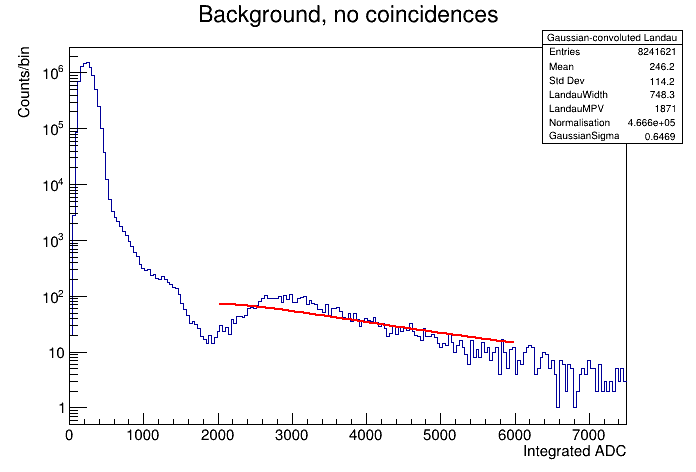

In [103]:
# Maybe it would be less confusing to include langaus in the same directory? I had trouble with this function because the file was not in the correct directory.
# %cd /home/coure/Software/caenqdc_custom/scripts/PECollectionStudies
from langaus import LanGausFit
# %cd - 

hpx.Draw()
# hpx.Fit("landau")
gPad.SetLogy();
gStyle.SetOptFit(2)
fit = LanGausFit()
func = fit.fit(hpx, fitrange=(2000,6000))
# The fitter return a ROOT TF1 (a 1D function).
# func.Print()
hpx.GetXaxis().SetTitle("Integrated ADC");
hpx.GetYaxis().SetTitle("Counts/bin");

hpx.Draw()
func.Draw("same")
c1.Draw()
# c1.SaveAs("Fitted_noCoincidences_swirlyTry2.pdf");


In [104]:
MPV = func.GetParameter(1) #This corresponds to the most probable value (MPV) of the distr.
print(MPV)

1871.3893079292068


### We can now use the muon dE/dx, the ADC/PE and the MPV to get the PE/MeV

In [105]:
muon_dE_dx = 2 #MeV/cm
panelWidth = 2.54 #cm
gainConversionFactor = 11#Check this with Samantha
#Then
pe_per_MeV = gainConversionFactor* MPV * 1/(ADC_to_PE) * 1/(muon_dE_dx*panelWidth)
print("PE/MeV = %0.2f"%pe_per_MeV) #PE/MeV

with open(figure_folder + '/' + 'PEMeV.txt', 'w') as f:
    f.write("PE/MeV = %0.2f"%pe_per_MeV)

PE/MeV = 40.12


## Extra Plots

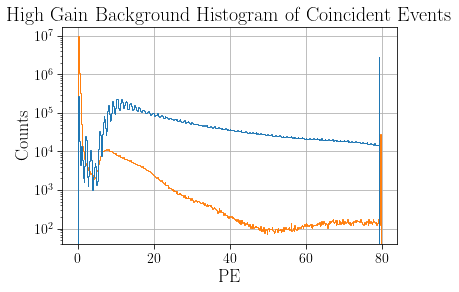

In [30]:
plt.hist((data['data']['high_gain']-ped)/spe, bins=500, range=(0,80),
         histtype='step');
plt.xlabel('~PE')
plt.ylabel('Counts')
plt.grid()
plt.yscale('log');
plt.title('High Gain Background Histogram of Coincident Events')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'HighGainPEBackgroundSpectrum_Coincidence.png')

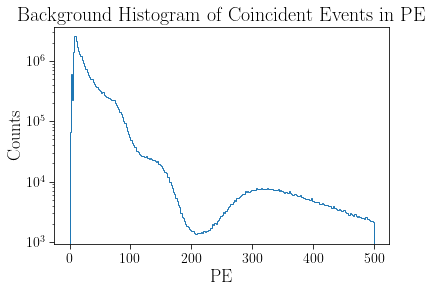

In [31]:
plt.hist((data['data']['low_gain'][:,0]-ped)*rat/spe, bins=250, range=(0,500),
         histtype='step');
plt.yscale('log')
plt.xlabel('~PE')
plt.ylabel('Counts')
plt.title('Background Histogram of Coincident Events in PE')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum_CoincidenceOnly.png')

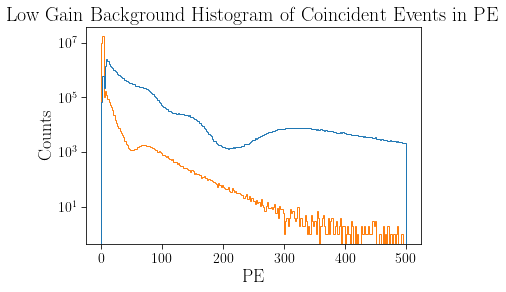

In [32]:
plt.hist((data['data']['low_gain']-ped)*rat/spe, bins=250, range=(0,500),
         histtype='step')
# plt.yscale('log');
# plt.ylim(0,2000);
plt.xlabel('~PE')
plt.yscale('log')
plt.ylabel('Counts')
# plt.vlines(35,0,20000)
plt.title('Low Gain Background Histogram of Coincident Events in PE')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'LowGainPEBackgroundSpectrum_Both.png')

In [33]:
mu = (data['data']['low_gain'][:,0]-ped)*rat/spe
len(mu[mu>180])/(data['header']['trigger_ts'][-1]-data['header']['trigger_ts'][0])

12.616726170542542

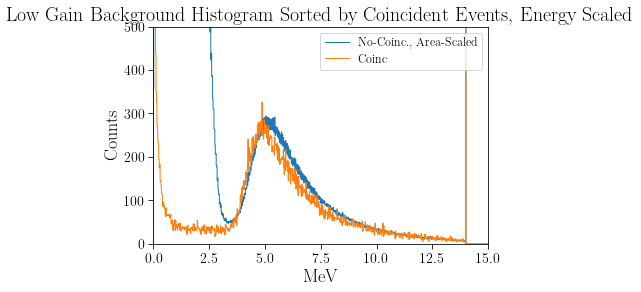

In [34]:
filter = data['data']['low_gain'][:,1] > 250
d = (data['data']['low_gain'][:,0]-ped)*rat/spe/pe_per_MeV

h1,bins = np.histogram(d, bins=740, range=(0,15))
h2,bins = np.histogram(d[filter], bins=740, range=(0,15))

area_ratio = (6*6)/(25*25)
plt.stairs(h1*area_ratio, bins, label='No-Coinc., Area-Scaled')
plt.stairs(h2, bins, label='Coinc')
plt.xlim(0,15)
plt.ylim(0,500)
plt.legend()
plt.xlabel('MeV')
plt.ylabel('Counts')
plt.vlines(x=265, ymin=0,ymax=5000, linestyles='--', color='k', alpha=0.5)
plt.title('Low Gain Background Histogram Sorted by Coincident Events, Energy Scaled')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum_Coincidence.png')